2025-07-04 14:03:14,574 - INFO - Using device: cpu
2025-07-04 14:03:14,579 - INFO - Starting Neural Network training with combined embeddings...
2025-07-04 14:03:14,580 - INFO - Loading iFeature_AAC embeddings...
2025-07-04 14:03:14,581 - INFO - Loading and extracting features for aac from ../data/embeddings/iFeature_AAC.csv...
2025-07-04 14:03:14,595 - INFO - Class distribution: Class 0: 859, Class 1: 861
2025-07-04 14:03:14,596 - INFO - iFeature_AAC dimensions: (1720, 20)
2025-07-04 14:03:14,596 - INFO - Loading Kidera_encoded embeddings...
2025-07-04 14:03:14,596 - INFO - Loading and extracting features for kidera from ../data/embeddings/Kidera_encoded.csv...
2025-07-04 14:03:14,605 - INFO - Class distribution: Class 0: 859, Class 1: 861
2025-07-04 14:03:14,605 - INFO - Kidera_encoded dimensions: (1720, 10)
2025-07-04 14:03:14,606 - INFO - Loading BLOSUM62_encoded embeddings...
2025-07-04 14:03:14,607 - INFO - Loading and extracting features for blosum from ../data/embeddings/BLOSUM

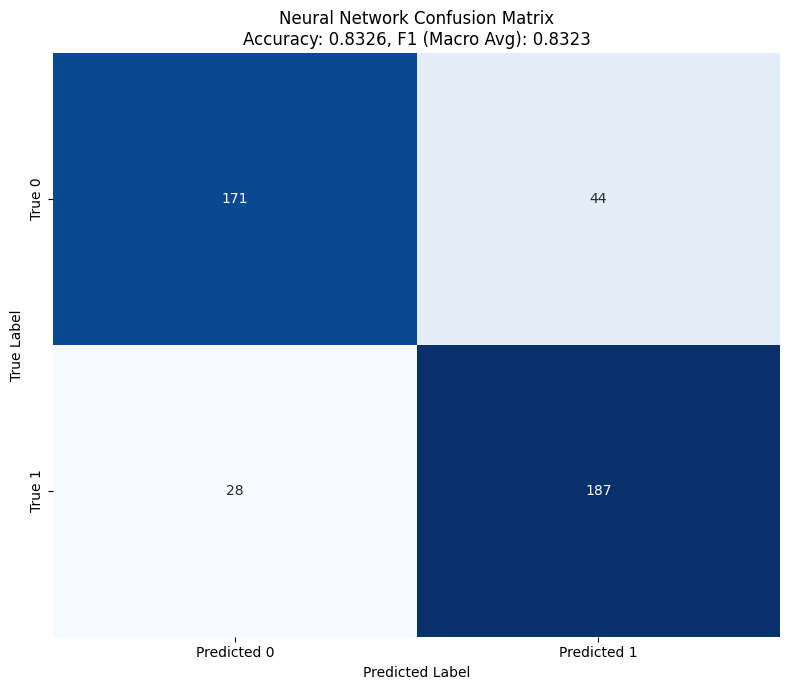

2025-07-04 14:03:23,987 - INFO - NN Loss curve saved to '../images/models/nn(1)_loss_curve.png'


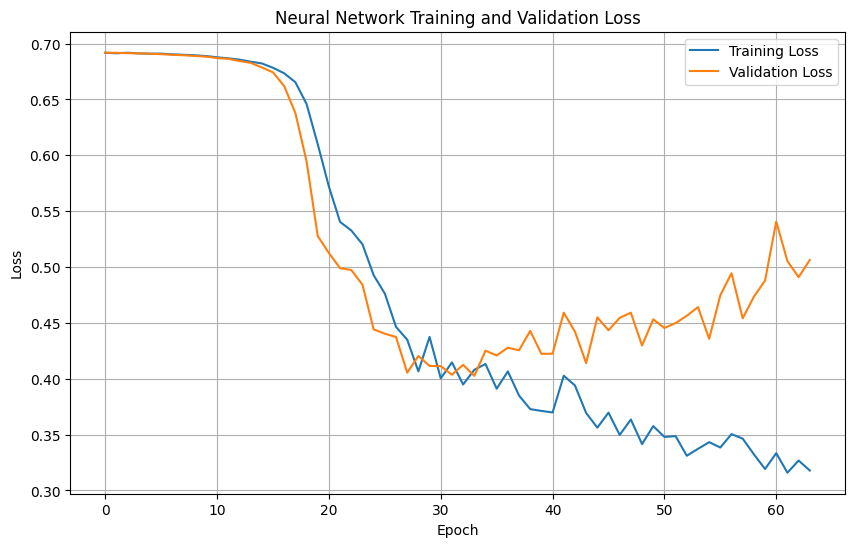

2025-07-04 14:03:24,047 - INFO - NN model and artifacts saved to './nn_model (1)'


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
import copy
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
import os
from tqdm import tqdm
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# --- Configuration ---
# Defines various parameters for data loading, model training, and hyperparameter grids.
config = {
    'aac_data_path': '../data/embeddings/iFeature_AAC.csv',
    'kidera_data_path': '../data/embeddings/Kidera_encoded.csv',
    'blosum_data_path': '../data/embeddings/BLOSUM62_encoded.csv',
    'intensity_threshold': 207500,
    'test_size': 0.25,
    'val_size': 0.2, # This is the validation size for the NN, taken from the train_val split
    'random_state': 42,
    'batch_size': 64,
    'epochs': 200,
    'patience': 30, # Early stopping patience
    'early_stopping_delta': 1e-6, # Minimum change in loss to qualify as an improvement
    'learning_rate': 0.001, # Initial learning rate for AdamW
    'min_lr': 1e-6, # Minimum LR for CyclicLR
    'max_lr': 0.01, # Maximum LR for CyclicLR
    'weight_decay': 1e-4, # L2 regularization for AdamW
    'hidden_dims_nn': [512, 256, 128, 64, 32], # Hidden layer dimensions for the NN
    'dropout_rates_nn': [0.5, 0.4, 0.3, 0.2, 0.1], # Dropout rates for NN layers
    'gradient_clip_norm': 1.0, # Gradient clipping to prevent exploding gradients
    'noise_magnitude': 0.03, # Magnitude of Gaussian noise for data augmentation
    'feature_selection_ratio': 0.8, # Ratio of features to select using SelectKBest
    'label_smoothing': 0.1, # Not directly used in BCEWithLogitsLoss but can be added
    'mixup_alpha': 0.2, # Alpha parameter for Mixup augmentation
    'ema_decay': 0.999, # Exponential Moving Average decay for NN weights
    'device': 'cuda' if torch.cuda.is_available() else 'cpu', # Device for PyTorch (GPU/CPU)
    'lr_scheduler_type': 'cyclic' # Type of learning rate scheduler for NN ('cyclic' or 'plateau')
}

# --- Seed Setting ---
def set_seed(seed: int) -> None:
    """
    Sets the random seed for reproducibility across numpy, random, and torch.
    Args:
        seed (int): The seed value to set.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Initialize logging and device
set_seed(config['random_state'])
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
device = torch.device(config['device'])
logging.info(f"Using device: {device}")

# --- Data Loading and Preprocessing ---
class FeatureDataset(Dataset):
    """
    Custom PyTorch Dataset for handling features and labels, with optional augmentation.
    Args:
        features (torch.Tensor): The feature tensor.
        labels (torch.Tensor): The label tensor.
        augment (bool): Whether to apply data augmentation. Defaults to False.
    """
    def __init__(self, features, labels, augment=False):
        self.features = features # Expects torch.Tensor features
        self.labels = labels     # Expects torch.Tensor labels
        self.augment = augment
        
    def __len__(self):
        """Returns the total number of samples."""
        return len(self.features)
    
    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset at the given index.
        Applies augmentation if self.augment is True.
        Args:
            idx (int): The index of the sample to retrieve.
        Returns:
            tuple: A tuple containing the features and labels for the given index.
        """
        x = self.features[idx]
        y = self.labels[idx]
        
        if self.augment:
            # Add Gaussian noise to features
            noise = torch.randn_like(x) * config['noise_magnitude']
            x = x + noise
            
            # Mixup augmentation: blend with another random sample
            if random.random() > 0.5 and config['mixup_alpha'] > 0:
                lam = np.random.beta(config['mixup_alpha'], config['mixup_alpha'])
                rand_idx = random.randint(0, len(self.features)-1)
                x2 = self.features[rand_idx]
                y2 = self.labels[rand_idx]
                x = lam * x + (1 - lam) * x2
                y = lam * y + (1 - lam) * y2
                
        return x, y

def load_and_extract_features(data_path: str, intensity_threshold: int, embedding_type: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Loads a CSV file, extracts features, and creates a binary target variable
    based on an intensity threshold.
    Args:
        data_path (str): The path to the CSV data file.
        intensity_threshold (int): The threshold for creating binary labels.
        embedding_type (str): The type of embedding ('aac', 'kidera', or 'blosum').
    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing features (X) and labels (y_class).
    """
    logging.info(f"Loading and extracting features for {embedding_type} from {data_path}...")
    try:
        df = pd.read_csv(data_path)
    except FileNotFoundError:
        logging.error(f"Error: Data file not found at {data_path}. Please check the path.")
        sys.exit(1) # Exit if file is not found
    except Exception as e:
        logging.error(f"Error loading CSV file: {e}")
        sys.exit(1) # Exit on other CSV loading errors

    if df.empty:
        logging.error("Error: Loaded CSV file is empty. No data to process.")
        sys.exit(1) # Exit if DataFrame is empty

    # Feature column selection based on embedding type
    if embedding_type == 'aac':
        # AAC features are typically single-letter amino acid counts (A-Y, excluding B, J, O, U, X, Z)
        # Using a more robust check for columns that might represent AACs
        feature_columns = [col for col in df.columns if len(col) == 1 and 'A' <= col <= 'Z' and col not in ['B', 'J', 'O', 'U', 'X', 'Z']]
        if not feature_columns:
            logging.warning("No standard single-letter AAC columns found. Attempting to use all columns except 'Intensity'.")
            feature_columns = [col for col in df.columns if col != 'Intensity']
        X = df.loc[:, feature_columns].values.astype(np.float32)
    elif embedding_type == 'kidera':
        # Kidera factors are typically named KF1 to KF10
        X = df.loc[:, "KF1": "KF10"].values.astype(np.float32)
    elif embedding_type == 'blosum':
        # BLOSUM features typically start with 'BLOSUM62_'
        blosum_cols = [col for col in df.columns if col.startswith('BLOSUM62_')]
        X = df.loc[:, blosum_cols].values.astype(np.float32)
    else:
        logging.error(f"Unknown embedding_type: {embedding_type}. Supported types are 'aac', 'kidera', and 'blosum'.")
        sys.exit(1) # Exit on unknown embedding type

    if 'Intensity' not in df.columns:
        logging.error("Error: 'Intensity' column not found in the CSV. Required for target variable creation.")
        sys.exit(1) # Exit if 'Intensity' column is missing

    # Create binary target variable based on threshold
    y_class = (df['Intensity'] > intensity_threshold).astype(int).values
    class_counts = np.bincount(y_class)
    logging.info(f"Class distribution: Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

    return X, y_class

def select_features(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, X_test: np.ndarray, k_ratio: float = 0.8) -> tuple:
    """
    Performs feature selection using SelectKBest with mutual_info_classif.
    Fits on training data and transforms training, validation, and test sets.
    Args:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels.
        X_val (np.ndarray): Validation features.
        X_test (np.ndarray): Test features.
        k_ratio (float): Ratio of features to select. Defaults to 0.8.
    Returns:
        tuple: A tuple containing the selected training, validation, test features, and the fitted selector.
    """
    k = int(X_train.shape[1] * k_ratio) # Determine number of features to select
    if k == 0: # Ensure at least one feature is selected if k_ratio leads to 0
        k = 1
    elif k > X_train.shape[1]: # Do not select more features than available
        k = X_train.shape[1]

    selector = SelectKBest(mutual_info_classif, k=k)
    # Fit and transform only on the training data
    X_train_selected = selector.fit_transform(X_train, y_train)
    # Transform validation and test data using the fitted selector
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)
    logging.info(f"Selected {k} features using mutual information from {X_train.shape[1]} original features")
    return X_train_selected, X_val_selected, X_test_selected, selector

def create_and_scale_splits(X: np.ndarray, y: np.ndarray, test_size: float, val_size: float, random_state: int) -> tuple:
    """
    Splits the data into training, validation, and test sets, and scales them.
    The scaler is fitted ONLY on the neural network's dedicated training portion (X_train_nn_raw)
    to prevent any potential data leakage from the validation or test sets.
    Args:
        X (np.ndarray): The full feature array.
        y (np.ndarray): The full label array.
        test_size (float): The proportion of the dataset to include in the test split.
        val_size (float): The proportion of the training/validation split to include in the validation split.
        random_state (int): Seed for random number generation.
    Returns:
        tuple: A tuple containing X_train_nn_scaled, y_train_nn, X_val_nn_scaled, y_val_nn,
               X_test_scaled, y_test, and the fitted StandardScaler.
    """
    # 1. Split into overall train_val and test sets (raw data)
    sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_val_idx, test_idx = next(sss_test.split(X, y))
    X_train_val_raw, X_test_raw = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]

    # 2. Split the train_val data into NN train and NN val sets (raw data)
    sss_nn_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
    train_nn_idx, val_nn_idx = next(sss_nn_val.split(X_train_val_raw, y_train_val))
    X_train_nn_raw = X_train_val_raw[train_nn_idx]
    X_val_nn_raw = X_train_val_raw[val_nn_idx]
    y_train_nn = y_train_val[train_nn_idx]
    y_val_nn = y_train_val[val_nn_idx]

    # 3. Fit scaler ONLY on X_train_nn_raw and transform all relevant sets
    scaler = StandardScaler()
    X_train_nn_scaled = scaler.fit_transform(X_train_nn_raw)
    X_val_nn_scaled = scaler.transform(X_val_nn_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    logging.info(f"NN Train dataset size: {len(X_train_nn_scaled)}")
    logging.info(f"NN Validation dataset size: {len(X_val_nn_scaled)}")
    logging.info(f"Final Test dataset size: {len(X_test_scaled)}")
    logging.info("Data scaled using StandardScaler (fitted ONLY on NN training data)")
    
    # Return all necessary splits and the scaler
    return (X_train_nn_scaled, y_train_nn, X_val_nn_scaled, y_val_nn, 
            X_test_scaled, y_test, scaler)

# --- Neural Network Architecture with Improvements ---
class ResidualBlock(nn.Module):
    """
    A Residual Block with two linear layers, BatchNorm, Dropout, and Swish activation.
    Includes a shortcut connection to facilitate training deeper networks.
    Args:
        in_dim (int): Input dimension of the block.
        out_dim (int): Output dimension of the block.
        dropout_rate (float): Dropout rate to apply.
    """
    def __init__(self, in_dim, out_dim, dropout_rate):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim)
        self.bn1 = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(out_dim, out_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)
        # Shortcut connection: identity if dimensions match, else a linear projection
        # Ensure the shortcut projection is also initialized correctly if dimensions differ
        self.shortcut = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()
        
    def forward(self, x):
        """
        Forward pass for the ResidualBlock.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor after passing through the block.
        """
        identity = self.shortcut(x) # Save input for shortcut connection
        out = self.linear1(x)
        out = self.bn1(out)
        out = F.silu(out)  # Swish activation (smoother than ReLU)
        out = self.dropout(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out += identity # Add shortcut connection output
        return F.silu(out) # Final activation

class AttentionPooling(nn.Module):
    """
    Attention mechanism to weigh different features within a sample.
    It takes a feature vector (batch_size, feature_dim) and outputs a re-weighted
    feature vector of the same dimension, where weights are learned via an attention sub-network.
    Args:
        feature_dim (int): The dimension of the input features.
    """
    def __init__(self, feature_dim):
        super().__init__()
        # This sub-network computes attention scores for each feature.
        # It takes (batch_size, feature_dim) and outputs (batch_size, feature_dim) raw attention scores.
        self.attention_score_generator = nn.Sequential(
            nn.Linear(feature_dim, feature_dim), # Projects features to themselves
            nn.Tanh(),                           # Non-linearity
            nn.Linear(feature_dim, feature_dim)  # Outputs a score for each feature
        )
        
    def forward(self, x):
        """
        Forward pass for the AttentionPooling.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, feature_dim).
        Returns:
            torch.Tensor: Attended features of shape (batch_size, feature_dim).
        """
        # x is (batch_size, feature_dim), e.g., (64, 32)
        raw_attention_scores = self.attention_score_generator(x) # (batch_size, feature_dim)
        
        # Apply softmax across the feature dimension (dim=1) to get weights that sum to 1 for each sample
        attention_weights = F.softmax(raw_attention_scores, dim=1) # (batch_size, feature_dim)
        
        # Perform element-wise multiplication with the original features to apply attention
        # This produces a re-weighted feature vector of the same dimension.
        attended_features = x * attention_weights # (batch_size, feature_dim)
        
        return attended_features # Return (batch_size, feature_dim)


class ClassifierNN(nn.Module):
    """
    Neural Network Classifier with Residual Blocks and Attention Pooling.
    Also includes Exponential Moving Average (EMA) for model weights.
    Args:
        input_dim (int): The dimension of the input features.
        hidden_dims (list[int]): A list of integers specifying the dimensions of hidden layers.
        dropout_rates (list[float]): A list of floats specifying dropout rates for each layer.
    """
    def __init__(self, input_dim: int, hidden_dims: list[int], dropout_rates: list[float]):
        super(ClassifierNN, self).__init__()
        layers = []
        
        # Initial projection layer to the first hidden dimension
        self.input_proj = nn.Linear(input_dim, hidden_dims[0])
        
        # Stack Residual Blocks
        for i in range(len(hidden_dims)-1):
            layers.append(ResidualBlock(hidden_dims[i], hidden_dims[i+1], dropout_rates[i]))
        
        self.res_blocks = nn.Sequential(*layers) # Group residual blocks
        
        # Attention pooling layer
        self.attention = AttentionPooling(hidden_dims[-1])
        
        # Output layer for binary classification (single output, no activation)
        # This layer now correctly expects input of shape (batch_size, hidden_dims[-1])
        self.out = nn.Linear(hidden_dims[-1], 1)
        
        # EMA model for stable predictions during inference
        self.ema_model = copy.deepcopy(self)
        for param in self.ema_model.parameters():
            param.requires_grad = False # EMA model parameters should not be updated by gradient descent directly

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Logits (raw scores) for the binary classification.
        """
        x = F.silu(self.input_proj(x)) # Apply initial projection and activation
        x = self.res_blocks(x)         # Pass through residual blocks
        x = self.attention(x)          # Apply attention pooling, output is (batch_size, hidden_dims[-1])
        return self.out(x)             # Final output (logits)
    
    def update_ema(self, decay=0.999):
        """
        Updates the EMA model's weights using a decay factor.
        Args:
            decay (float): The decay factor for the EMA. Defaults to 0.999.
        """
        with torch.no_grad(): # No gradient calculation needed for EMA update
            for param, ema_param in zip(self.parameters(), self.ema_model.parameters()):
                ema_param.data = decay * ema_param.data + (1 - decay) * param.data

# --- Early Stopping Helper Class ---
class EarlyStopping:
    """
    Monitors a validation metric and stops training when the metric
    does not improve for a certain number of epochs (patience).
    Also saves the best model weights.
    Args:
        patience (int): Number of epochs to wait for improvement before stopping. Defaults to 10.
        delta (float): Minimum change to qualify as an improvement. Defaults to 0.0.
    """
    def __init__(self, patience: int = 10, delta: float = 0.0):
        self.patience = patience
        self.delta = delta # Minimum change to qualify as an improvement
        self.best_loss = float('inf') # Initialize with infinity
        self.counter = 0 # Counter for epochs without improvement
        self.best_model_wts = None # To store best model weights
        self.early_stop = False # Flag for early stopping

    def __call__(self, val_loss: float, model: nn.Module) -> bool:
        """
        Call method to update early stopping status based on current validation loss.
        Args:
            val_loss (float): The current validation loss.
            model (nn.Module): The model being trained.
        Returns:
            bool: True if early stopping should be triggered, False otherwise.
        """
        if val_loss < self.best_loss - self.delta: # If loss improves
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict()) # Save current model weights
            self.counter = 0 # Reset counter
        else: # If loss does not improve
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True # Trigger early stopping
        return self.early_stop

    def load_best_weights(self, model: nn.Module) -> None:
        """
        Loads the best saved model weights back into the model.
        Args:
            model (nn.Module): The model to load weights into.
        """
        if self.best_model_wts:
            model.load_state_dict(self.best_model_wts)
            logging.info("Loaded best model weights based on validation loss.")
        else:
            logging.warning("No best model weights saved.")

# --- Learning Rate Finder (utility, not used in main execution by default) ---
def find_learning_rate(model, train_loader, criterion, optimizer, device, min_lr=1e-7, max_lr=1, num_iters=100):
    """
    Performs a learning rate range test to help find an optimal learning rate.
    Increases LR linearly and records loss.
    Args:
        model (nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for the training data.
        criterion (nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        device (torch.device): The device (CPU/GPU) for training.
        min_lr (float): Minimum learning rate to test. Defaults to 1e-7.
        max_lr (float): Maximum learning rate to test. Defaults to 1.
        num_iters (int): Number of iterations for the test. Defaults to 100.
    Returns:
        tuple: Lists of learning rates and corresponding losses.
    """
    model.train()
    lr_mult = (max_lr / min_lr) ** (1/num_iters) # Multiplicative factor for LR
    lr = min_lr
    optimizer.param_groups[0]['lr'] = lr # Set initial LR
    
    losses = []
    lrs = []
    
    for i, (inputs, targets) in enumerate(train_loader):
        if i >= num_iters:
            break
            
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets.float())
        
        # Backpropagate and update weights
        loss.backward()
        optimizer.step()
        
        # Update learning rate
        lr *= lr_mult
        optimizer.param_groups[0]['lr'] = lr
        
        # Track loss and learning rate
        losses.append(loss.item())
        lrs.append(lr)
        
    return lrs, losses

# --- Training and Evaluation Functions ---
def train_nn_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    early_stopper: EarlyStopping,
    epochs: int,
    device: torch.device,
    gradient_clip_norm: float
) -> tuple[nn.Module, list, list]: # Modified return type to include losses
    """
    Trains the neural network model, including validation, scheduling, and early stopping.
    Args:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        criterion (nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler.
        early_stopper (EarlyStopping): The early stopping instance.
        epochs (int): The maximum number of epochs to train.
        device (torch.device): The device (CPU/GPU) for training.
        gradient_clip_norm (float): The maximum norm for gradient clipping.
    Returns:
        tuple[nn.Module, list, list]: The best trained model, a list of training losses per epoch,
                                     and a list of validation losses per epoch.
    """
    logging.info(f"Starting Neural Network training for up to {epochs} epochs...")
    best_epoch = 0 # To record the epoch when the best model was saved
    train_losses = [] # List to store training loss per epoch
    val_losses = []   # List to store validation loss per epoch
    
    for epoch in range(1, epochs + 1):
        model.train() # Set model to training mode
        current_train_loss = 0.0
        # Use tqdm for a progress bar during training
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        
        for xb, yb in progress_bar:
            xb, yb = xb.to(device), yb.to(device) # Move data to the specified device
            optimizer.zero_grad() # Clear previous gradients
            preds = model(xb).squeeze() # Forward pass
            loss = criterion(preds, yb.float()) # Calculate loss
            loss.backward() # Backpropagation
            
            # Apply gradient clipping if enabled
            if gradient_clip_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_norm)
                
            optimizer.step() # Update model parameters
            model.update_ema(config['ema_decay']) # Update EMA model weights
            
            current_train_loss += loss.item() * xb.size(0) # Accumulate batch loss
            progress_bar.set_postfix(loss=loss.item()) # Update progress bar with current batch loss
            
        current_train_loss /= len(train_loader.dataset) # Average training loss
        train_losses.append(current_train_loss) # Store training loss

        # Validation phase
        model.eval() # Set model to evaluation mode
        current_val_loss = 0.0
        with torch.no_grad(): # Disable gradient calculation for validation
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).squeeze()
                loss = criterion(preds, yb.float())
                current_val_loss += loss.item() * xb.size(0)
        current_val_loss /= len(val_loader.dataset) # Average validation loss
        val_losses.append(current_val_loss) # Store validation loss

        # Step learning rate scheduler
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(current_val_loss) # ReduceLROnPlateau steps based on a metric
        else:
            scheduler.step() # Other schedulers (like CyclicLR) step every epoch/iteration

        logging.info(f"  NN Epoch {epoch}/{epochs} - Train Loss: {current_train_loss:.4f}, Val Loss: {current_val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Check for early stopping
        if early_stopper(current_val_loss, model):
            logging.info(f"  NN Early stopping triggered at epoch {epoch}. Restoring best model weights.")
            best_epoch = epoch
            break # Exit training loop
            
        if epoch == epochs: # If training completes all epochs
            best_epoch = epoch

    early_stopper.load_best_weights(model) # Load the best model weights before returning
    logging.info(f"Training completed. Best epoch: {best_epoch}")
    return model, train_losses, val_losses # Return best model and loss lists

def evaluate_classifier_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_prob: np.ndarray = None, model_name: str = "Model") -> tuple:
    """
    Calculates and logs common classification metrics (accuracy, F1, precision, recall, ROC AUC, confusion matrix).
    Reports F1-score for each class separately.
    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        y_prob (np.ndarray, optional): Predicted probabilities. Defaults to None.
        model_name (str, optional): Name of the model for logging. Defaults to "Model".
    Returns:
        tuple: A tuple containing accuracy, macro F1, precision, recall, ROC AUC, and confusion matrix.
    """
    accuracy = accuracy_score(y_true, y_pred)
    f1_per_class = f1_score(y_true, y_pred, average=None) # F1-score for each class
    f1_macro = f1_score(y_true, y_pred, average='macro') # Macro F1 for overall understanding
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    roc_auc = np.nan # Initialize ROC AUC to NaN
    if y_prob is not None and len(np.unique(y_true)) > 1: # ROC AUC requires probabilities and at least two classes
        try:
            roc_auc = roc_auc_score(y_true, y_prob)
        except ValueError as e:
            logging.warning(f"Error computing ROC AUC for {model_name}: {e}") # Log if ROC AUC cannot be computed

    logging.info(f"\n--- {model_name} Results ---")
    logging.info(f"Accuracy: {accuracy:.4f}")
    logging.info(f"F1-score (Class 0): {f1_per_class[0]:.4f}")
    logging.info(f"F1-score (Class 1): {f1_per_class[1]:.4f}")
    logging.info(f"F1-score (Macro Avg): {f1_macro:.4f}")
    logging.info(f"Precision: {precision:.4f}")
    logging.info(f"Recall: {recall:.4f}")
    logging.info(f"ROC AUC: {roc_auc:.4f}")
    logging.info(f"Confusion Matrix:\n{cm}")

    return accuracy, f1_macro, precision, recall, roc_auc, cm

# --- Main Script Execution for NN Only ---
def main():
    """
    Main function to orchestrate data loading, preprocessing, neural network training, and evaluation.
    """
    logging.info("Starting Neural Network training with combined embeddings...")

    # Load and preprocess data from various embedding types
    logging.info("Loading iFeature_AAC embeddings...")
    X_aac, y_class_aac = load_and_extract_features(config['aac_data_path'], config['intensity_threshold'], 'aac')
    logging.info(f"iFeature_AAC dimensions: {X_aac.shape}")

    logging.info("Loading Kidera_encoded embeddings...")
    X_kidera, y_class_kidera = load_and_extract_features(config['kidera_data_path'], config['intensity_threshold'], 'kidera')
    logging.info(f"Kidera_encoded dimensions: {X_kidera.shape}")

    logging.info("Loading BLOSUM62_encoded embeddings...")
    X_blosum, y_class_blosum = load_and_extract_features(config['blosum_data_path'], config['intensity_threshold'], 'blosum')
    logging.info(f"BLOSUM62_encoded dimensions: {X_blosum.shape}")

    # Verify target consistency across different embedding files
    if not (np.array_equal(y_class_aac, y_class_kidera) and np.array_equal(y_class_aac, y_class_blosum)):
        logging.error("Target variables from different embeddings are not identical. Check input data alignment.")
        sys.exit(1) # Exit if targets don't match
    y_class = y_class_aac # Use one of them as the definitive target

    # Combine features horizontally
    X_combined = np.hstack((X_aac, X_kidera, X_blosum))
    logging.info(f"Combined feature dimensions: {X_combined.shape}")

    # Create data splits and apply global scaling
    # This function ensures that the scaler is fitted ONLY on the training data.
    (X_train_nn_scaled, y_train_nn, X_val_nn_scaled, y_val_nn, 
     X_test_scaled, y_test, scaler) = \
        create_and_scale_splits(X_combined, y_class, config['test_size'], config['val_size'], config['random_state'])

    # Apply feature selection to the scaled data
    # The feature selector is also fit ONLY on the training data.
    X_train_nn_selected, X_val_nn_selected, X_test_selected, feature_selector = \
        select_features(X_train_nn_scaled, y_train_nn, X_val_nn_scaled, X_test_scaled, 
                        config['feature_selection_ratio'])
    
    input_dim_selected = X_train_nn_selected.shape[1] # Actual input dimension for the NN

    # Prepare PyTorch datasets from the selected and scaled features
    tensor_X_train_nn = torch.tensor(X_train_nn_selected, dtype=torch.float32)
    tensor_y_train_nn = torch.tensor(y_train_nn, dtype=torch.float32)
    tensor_X_val_nn = torch.tensor(X_val_nn_selected, dtype=torch.float32)
    tensor_y_val_nn = torch.tensor(y_val_nn, dtype=torch.float32)
    tensor_X_test = torch.tensor(X_test_selected, dtype=torch.float32)
    tensor_y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create datasets with augmentation for training data
    train_nn_ds = FeatureDataset(tensor_X_train_nn, tensor_y_train_nn, augment=True)
    val_nn_ds = TensorDataset(tensor_X_val_nn, tensor_y_val_nn)
    test_nn_ds = TensorDataset(tensor_X_test, tensor_y_test)

    # Create DataLoaders for batching and shuffling
    train_nn_loader = DataLoader(train_nn_ds, batch_size=config['batch_size'], shuffle=True)
    val_nn_loader = DataLoader(val_nn_ds, batch_size=config['batch_size'], shuffle=False)
    test_nn_loader = DataLoader(test_nn_ds, batch_size=config['batch_size'], shuffle=False)

    # Calculate class weights for neural network's BCEWithLogitsLoss to handle imbalance
    count_class_0 = np.sum(y_train_nn == 0)
    count_class_1 = np.sum(y_train_nn == 1)
    # Assign higher weight to the minority class
    pos_weight = count_class_0 / count_class_1 if count_class_1 > 0 else 1.0
    logging.info(f"Positive class weight for NN: {pos_weight:.4f}")

    # Initialize neural network model, loss function, and optimizer
    nn_model = ClassifierNN(input_dim_selected, config['hidden_dims_nn'], config['dropout_rates_nn']).to(device)
    nn_criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))
    nn_optimizer = torch.optim.AdamW(nn_model.parameters(), lr=config['learning_rate'], 
                                     weight_decay=config['weight_decay'])

    # Select and initialize learning rate scheduler
    if config['lr_scheduler_type'] == 'cyclic':
        nn_scheduler = CyclicLR(nn_optimizer, base_lr=config['min_lr'], max_lr=config['max_lr'],
                                step_size_up=2000, cycle_momentum=False)
        logging.info("Using CyclicLR learning rate scheduler")
    else: # Default to ReduceLROnPlateau
        nn_scheduler = ReduceLROnPlateau(nn_optimizer, 'min', patience=config['patience']//2, 
                                         factor=0.5, verbose=True)
        logging.info("Using ReduceLROnPlateau learning rate scheduler")

    # Initialize early stopping
    nn_early_stopper = EarlyStopping(patience=config['patience'], delta=config['early_stopping_delta'])

    # Train the neural network model
    # Capture the returned training and validation losses
    best_nn_model, train_losses, val_losses = train_nn_model(
        nn_model, train_nn_loader, val_nn_loader, nn_criterion,
        nn_optimizer, nn_scheduler, nn_early_stopper,
        config['epochs'], device, config['gradient_clip_norm']
    )

    # Evaluate the trained neural network on the test set
    best_nn_model.eval() # Set NN to evaluation mode for inference
    nn_test_probs_list = []
    with torch.no_grad(): # Disable gradient calculation
        for xb, _ in test_nn_loader:
            xb = xb.to(device)
            outputs = best_nn_model(xb).squeeze()
            nn_test_probs_list.extend(torch.sigmoid(outputs).cpu().numpy()) # Convert logits to probabilities
    nn_test_probs = np.array(nn_test_probs_list)
    nn_test_preds = (nn_test_probs > 0.5).astype(int) # Convert probabilities to binary predictions

    nn_acc, nn_f1_macro, nn_prec, nn_rec, nn_roc_auc, nn_cm = evaluate_classifier_metrics(
        y_test, nn_test_preds, nn_test_probs, "Neural Network (Test)"
    )

    # Plot confusion matrix for the NN model
    fig, ax = plt.subplots(figsize=(8, 7))
    sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['True 0', 'True 1'], ax=ax)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(f"Neural Network Confusion Matrix\nAccuracy: {nn_acc:.4f}, F1 (Macro Avg): {nn_f1_macro:.4f}")
    
    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plot_save_path_cm = '../images/models/nn(1)_confusion_matrix.png'
    os.makedirs(os.path.dirname(plot_save_path_cm), exist_ok=True) # Ensure images directory exists
    plt.savefig(plot_save_path_cm) # Save the plot
    logging.info(f"NN Confusion matrix saved to '{plot_save_path_cm}'")
    plt.show() # Display the plot

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Neural Network Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plot_save_path_loss = '../images/models/nn(1)_loss_curve.png'
    os.makedirs(os.path.dirname(plot_save_path_loss), exist_ok=True) # Ensure images directory exists
    plt.savefig(plot_save_path_loss, dpi=300) # Save the plot
    logging.info(f"NN Loss curve saved to '{plot_save_path_loss}'")
    plt.show() # Display the plot

    # Save the trained NN model and important artifacts
    models_dir = './nn_model (1)'
    os.makedirs(models_dir, exist_ok=True) # Create directory if it doesn't exist
    
    torch.save(best_nn_model.state_dict(), os.path.join(models_dir, 'best_nn_model.pt'))
    joblib.dump(scaler, os.path.join(models_dir, 'scaler.pkl')) # Save the scaler
    joblib.dump(feature_selector, os.path.join(models_dir, 'feature_selector.pkl')) # Save the feature selector
    
    logging.info(f"NN model and artifacts saved to '{models_dir}'")

if __name__ == "__main__":
    main()